# PV3 Database access and data visualisations - WR

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Imports

In [1]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v1 (jupyter)'
project = 'pv3'

# Database Connection

In [2]:
def postgres_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = 'localhost' # input('host (default 130.226.55.43): ')
    port = '5434' # input('port (default 5432): ')
    database = 'sonnja_db' # input("database name (default 'reeem'): ")
    user = 'sonnja' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()

D:\Anaconda3\envs\d_py37_vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Data Analysis

## Select table metadata

This section can be used to get the metadata from one database table.<br>
The result is printed.<br>

In [3]:
# Database select (SQL)
sql = text("""SELECT obj_description('pv3.einleuchtend_wrdata_2015_wr1'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']
print(meta_str)

{
    "title": "einleuchtend e.V. inverter 1 (WR1)",
    "description": "SonnJa! measurement data",
    "language": [ "eng" ],
    "sources": [
        {"name": "einleuchtend e.V.", 
        "description": "SonnJa! measurement data", 
        "url": "http://einleuchtend.org/sonn-ja/daten-fakten/", 
        "license": "none", 
        "copyright": "© einleuchtend e.V."} ],
    "spatial": [
        {"location": "52.455778° N, 13.523917° O",
        "extent": "none",
        "resolution": "none"} ],
    "temporal": [
        {"reference_date": "none",
        "start": "2015-01-01",
        "end": "2015-31-12",
        "resolution": "minute"} ],
    "license": [
        {"id": "none",
        "name": "none",
        "version": "none",
        "url": "none",
        "instruction": "For scientific purposes and teaching only!",
        "copyright": "© einleuchtend e.V."} ],
    "contributors": [
        {"name": "Ludwig Hülk", "email": "none", "date": "2017-06-14", "comment": "Create metadata

In [4]:
text_name = r'data/einleuchtend_wrdata_2015_wr1_metadata.txt'
with open(text_name, "w") as text_file:
    print(meta_str, file=text_file)
print("Metadata saved to file:", text_name)

Metadata saved to file: data/einleuchtend_wrdata_2015_wr1_metadata.txt


## Select all WR

In [5]:
# Database select (SQL)
sql = text("""
    SELECT  timestamp, wr1_p_ac, wr2_p_ac, wr3_p_ac, wr4_p_ac, wr5_p_ac   -- column
    FROM    pv3.data_all_wr_2015_mview  -- table
    """)
df = pd.read_sql_query(sql, con)
df = df.set_index('timestamp')

### Plot all WR (takes a minute)

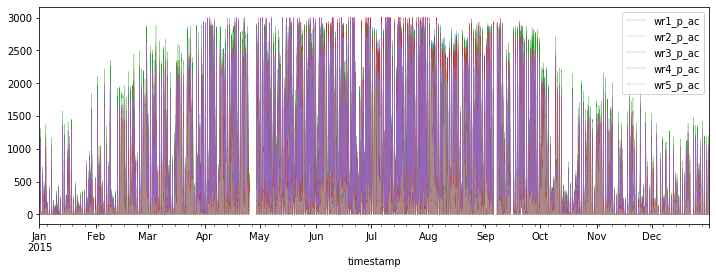

In [6]:
ax = df.plot(figsize=(12, 4), lw=0.25)

### Resample to 1 hour

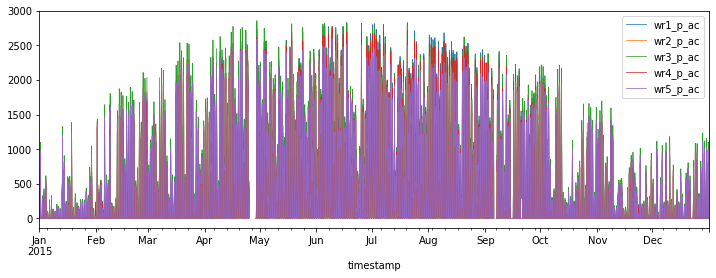

In [7]:
df_reH = df.resample('1H').mean()
ax = df_reH.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 day

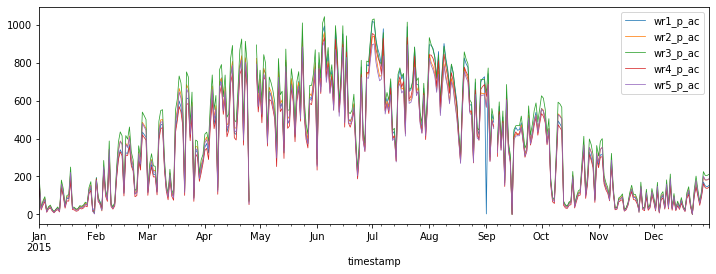

In [8]:
df_reD = df.resample('1D').mean()
ax = df_reD.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 month

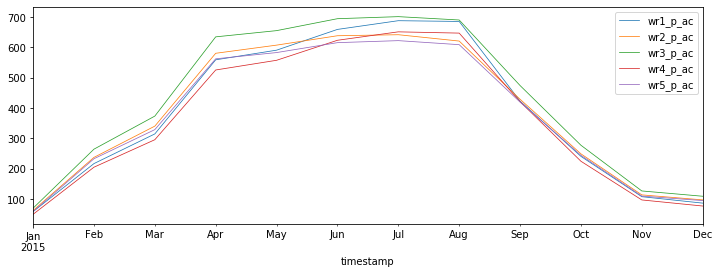

In [9]:
df_reM = df.resample('1M').mean()
ax = df_reM.plot(figsize=(12, 4), lw=0.75)

### Bar plot per month

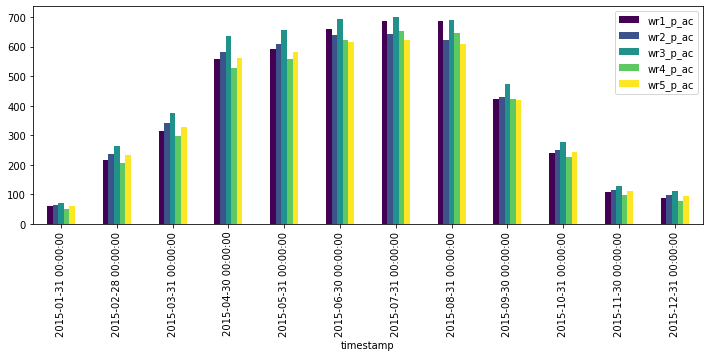

In [10]:
df_reM = df.resample('1M').mean()
ax = df_reM.plot.bar(figsize=(12, 4), stacked=False, colormap='viridis')

# Metadata

The important information from the above select (**df**) is collected in a Dictionary (**info_dict**).

In [11]:
# Facts dict
info_dict = {}
info_dict['Filename'] = ['{}_pv3_sonnja_plot_all_wr' .format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Leistung (P_AC)']
info_dict['Unit'] = ['W']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Stunde im Jahr']
info_dict['Title'] = ['Alle Wechselrichter']
info_dict['Metadata'] = [meta_str]

# Print facts
# for x in info_dict:
#     print(x,':',info_dict[x])

## Plot with Metadata

(0, 3000.0249999999996)

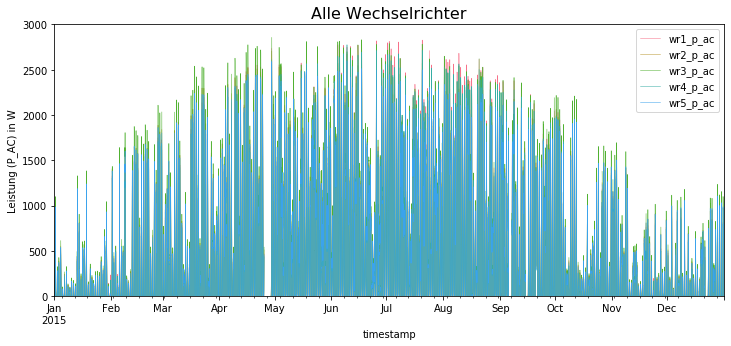

In [12]:
sns.set_palette("husl")
mfig = plt.figure(figsize=(12, 5))
ax = plt.subplot()
plt.title(*info_dict['Title'], fontsize=16)         # Title from info
plt.ylabel(*info_dict['Y-Axis'])                    # Label from info
df.resample('1H').mean().plot(ax=ax, lw=0.5, markeredgewidth=3)
ax.set_ylim(ymin=0)

## Interactive Plot with Metadata

In [13]:
# Interactive plot
data = [
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr1_p_ac'].tolist(), 
               name='WR1', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr2_p_ac'].tolist(), 
               name='WR2', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr3_p_ac'].tolist(), 
               name='WR3', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr4_p_ac'].tolist(), 
               name='WR4', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr5_p_ac'].tolist(), 
               name='WR5', line=dict(), mode='lines')]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
fig = go.Figure(data=data, layout=layout)
pltly.iplot(fig)

### One WR

In [14]:
# Interactive plot
sns.set_style('ticks')
trace_line = go.Scatter(x=df_reD.index.tolist(), 
                        y=df_reD['wr1_p_ac'].tolist(), 
                        name='WR1 täglich', line=dict(), mode='lines')
trace_bar = go.Bar(x=df_reM.index.tolist(), 
                   y=df_reM['wr1_p_ac'].tolist(), 
                   name='WR1 monatlich', marker=dict())
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig = go.Figure(data=[trace_bar, trace_line], layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [15]:
# Write facts to textfile
txtname = ('data/{}.txt').format(*info_dict['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict['Filename'])
df_reH.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict['Filename'])
mfig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/2020-05-12_pv3_sonnja_plot_all_wr.txt
Data saved to file: data/2020-05-12_pv3_sonnja_plot_all_wr.csv
Plot saved to file: data/2020-05-12_pv3_sonnja_plot_all_wr.png
Interactive plot saved to file: data/2020-05-12_pv3_sonnja_plot_all_wr.html
